In [0]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential, Model
from keras.layers import Activation, Dense, LSTM, Dropout, Masking, Input
from keras import optimizers
from keras.utils.vis_utils import model_to_dot

from IPython.display import SVG

from google.colab import files

# Initial Data Importation and Structuring

## Accessing and loading data from Google Drive 



In [14]:
# mounting Google Drive which contains the relevant data

from google.colab import drive
drive.mount('/content/drive')

# 4/ZwFoT8CKuomgNmyvFZMDEuEj_Fjq89ibCm76aAsCKjn-sLxwohkSa1I

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Fundamental input data
ltm_book = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ltm_book.csv')
ltm_div = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ltm_div.csv')
ltm_ebit = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ltm_ebit.csv')
ltm_eps = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ltm_eps.csv')
ltm_fcf = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ltm_fcf.csv')
ltm_pbook = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ltm_pbook.csv')
ltm_sales = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ltm_sales.csv')

ntm_book = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ntm_book.csv')
ntm_div = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ntm_div.csv')
ntm_ebit = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ntm_ebit.csv')
ntm_eps = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ntm_eps.csv')
ntm_fcf = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ntm_fcf.csv')
ntm_pbook = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ntm_pbook.csv')
ntm_sales = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ntm_sales.csv')

# Technical input data

price_high = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/price_high.csv')
price_low = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/price_low.csv')
price_open = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/price_open.csv')
volume = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/volume.csv')
enterprise_val = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/enterprise_val.csv')
market_cap = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/market_cap.csv')

print(ltm_book.head())
print("**************************************")
print(ltm_book.info())


# Price target output data

price_close = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/price_close.csv')

print(price_close.head())
print("**************************************")
print(price_close.info())


# Test data

# test_data = pd.read_csv("/content/drive/My Drive/thw116_FYP/data/test_price.csv")

# print(test_data.head())
# print("**************************************")
# print(test_data.info())

   Unnamed: 0  ATRS AV  ESSR LN  ...  FABGB SS  926002Q GY  NDA SS
0           1      NaN      NaN  ...       NaN         NaN     NaN
1           2      NaN      NaN  ...       NaN         NaN     NaN
2           3      NaN      NaN  ...       NaN         NaN     NaN
3           4      NaN      NaN  ...       NaN         NaN     NaN
4           5      NaN      NaN  ...       NaN         NaN     NaN

[5 rows x 1185 columns]
**************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6313 entries, 0 to 6312
Columns: 1185 entries, Unnamed: 0 to NDA SS
dtypes: float64(1184), int64(1)
memory usage: 57.1 MB
None
   Unnamed: 0  PAYS LN  CNHI IM     SGSN SW  ...  AMS SM  FER SM  SEV FP    FKI LN
0  1995-01-03      NaN      NaN  222.552843  ...     NaN     NaN     NaN  1.896782
1  1995-01-04      NaN      NaN  226.835424  ...     NaN     NaN     NaN  1.883390
2  1995-01-05      NaN      NaN  228.312320  ...     NaN     NaN     NaN  1.910292
3  1995-01-06      NaN   

##Restructuring and Standardising the datasets

In [16]:
# Filtering incorrect datasets to suitable company subsets
industrials_subset = price_close.columns.values.tolist()

ltm_inputs = [ltm_book, ltm_div, ltm_ebit, ltm_eps, ltm_fcf, ltm_pbook, ltm_sales] 
ntm_inputs = [ntm_book, ntm_div, ntm_ebit, ntm_eps, ntm_fcf, ntm_pbook, ntm_sales]
tech_inputs = [price_high, price_low, price_open, volume, enterprise_val, market_cap]

for i in range(0,len(ltm_inputs)):
  ltm_inputs[i] = ltm_inputs[i].loc[:, ltm_inputs[i].columns.str.contains('|'.join(industrials_subset))]
  ltm_inputs[i]['Unnamed: 0'] = price_close['Unnamed: 0']
  ltm_inputs[i].rename( columns={'Unnamed: 0':'Date'}, inplace=True )

for i in range(0,len(ntm_inputs)):
  ntm_inputs[i] = ntm_inputs[i].loc[:, ntm_inputs[i].columns.str.contains('|'.join(industrials_subset))]
  ntm_inputs[i]['Unnamed: 0'] = price_close['Unnamed: 0']
  ntm_inputs[i].rename( columns={'Unnamed: 0':'Date'}, inplace=True )

for i in range(0,len(tech_inputs)):
  tech_inputs[i] = tech_inputs[i].loc[:, tech_inputs[i].columns.str.contains('|'.join(industrials_subset))]
  tech_inputs[i]['Unnamed: 0'] = price_close['Unnamed: 0']
  tech_inputs[i].rename( columns={'Unnamed: 0':'Date'}, inplace=True )

  
price_close.rename( columns={'Unnamed: 0':'Date'}, inplace=True )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

## Data Wrangling

In order to produce a dataframe suitable for the model, we must first take the raw *Price.csv*  file and convert it to returns. This can then be maniuplated further in a variety of ways to achieve the neccessary classification for variants of the model

###Date Index Generator

In [17]:
# Conversion of TimeAndDate column to DatetimeIndex for ease of use

def time_index_generator(dataframe):
  dataframe['Date'] = pd.to_datetime(dataframe['Date'], dayfirst=True)
  dataframe.set_index('Date', inplace=True)


for i in range(0,len(ltm_inputs)):
  time_index_generator(ltm_inputs[i])
for i in range(0,len(ntm_inputs)):
  time_index_generator(ntm_inputs[i])
for i in range(0,len(tech_inputs)):
  time_index_generator(tech_inputs[i])  

time_index_generator(price_close)
  
print(ltm_inputs[0].head(2))
print(ntm_inputs[0].head(2))
print(tech_inputs[0].head(2))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


            PAYS LN  CNHI IM  SGSN SW  PAGE LN  ...  AMS SM  FER SM  SEV FP  FKI LN
Date                                            ...                                
1995-01-03      NaN      NaN      NaN      NaN  ...     NaN     NaN     NaN     NaN
1995-01-04      NaN      NaN      NaN      NaN  ...     NaN     NaN     NaN     NaN

[2 rows x 203 columns]
            PAYS LN  CNHI IM  SGSN SW  PAGE LN  ...  AMS SM  FER SM  SEV FP  FKI LN
Date                                            ...                                
1995-01-03      NaN      NaN      NaN      NaN  ...     NaN     NaN     NaN     NaN
1995-01-04      NaN      NaN      NaN      NaN  ...     NaN     NaN     NaN     NaN

[2 rows x 203 columns]
            PAYS LN  CNHI IM     SGSN SW  ...  FER SM  SEV FP   FKI LN
Date                                      ...                         
1995-01-03      NaN      NaN  222.552843  ...     NaN     NaN  1.91608
1995-01-04      NaN      NaN  232.668335  ...     NaN     NaN  1.90

In [0]:
# Check all columns align correctly
print(ltm_inputs[0].columns.difference(price_close.columns))
print(ltm_inputs[1].columns.difference(price_close.columns))
print(ltm_inputs[2].columns.difference(price_close.columns))
print(ltm_inputs[3].columns.difference(price_close.columns))


###Ticker Anonymisation 


In [18]:
# Check that all tickers in the set match

# Helper function to generate ticker list
def ticker_list_generator(num):
  ticker_list = []
  for i in range(0, num):
    ticker_name = 'Ticker ' + str(i+1)
    ticker_list.append(ticker_name)
  return ticker_list

anon_tickers = ticker_list_generator(len(ltm_inputs[0].columns))

for i in range(0,len(ltm_inputs)):
  ltm_inputs[0].columns = anon_tickers
for i in range(0,len(ntm_inputs)):
  ntm_inputs[0].columns = anon_tickers
for i in range(0,len(tech_inputs)):
  tech_inputs[0].columns = anon_tickers

price_close.columns = anon_tickers

print(ltm_inputs[0].head(2))

            Ticker 1  Ticker 2  Ticker 3  ...  Ticker 201  Ticker 202  Ticker 203
Date                                      ...                                    
1995-01-03       NaN       NaN       NaN  ...         NaN         NaN         NaN
1995-01-04       NaN       NaN       NaN  ...         NaN         NaN         NaN

[2 rows x 203 columns]


In [0]:
# Selecting a Ticker and plotting

# test_data['Ticker 1'].plot(figsize=(16,6))
# plt.title('Test Results - Ticker 1')
# plt.xlabel('Date')
# plt.ylabel('Attribute')

# test_data.plot(figsize=(16,6))

ltm_inputs[0]['Ticker 1'].plot(figsize=(16,6))
plt.title('ltm_book - Ticker 1')
plt.xlabel('Date')
plt.ylabel('Attribute')

###Price to Returns Converter

In [19]:
# Converting Price format to returns format
def price_to_returns(timeframe, dataframe):
  if timeframe == 'daily':
    return dataframe.pct_change(1) # remember to discount all target variables that are NaN
  
  if timeframe == 'monthly':
    return dataframe.resample('BM')
  
returns = price_to_returns('daily', price_close) 

print(returns.head(2))

            Ticker 1  Ticker 2  Ticker 3  ...  Ticker 201  Ticker 202  Ticker 203
Date                                      ...                                    
1995-01-03       NaN       NaN       NaN  ...         NaN         NaN         NaN
1995-01-04       NaN       NaN  0.019243  ...         NaN         NaN    -0.00706

[2 rows x 203 columns]


# Data Preprocessing

Several steps are taken in order to structure the data so that it can be proccessed by the model.

1.   Data Analysis and Cleaning: Data is analysed for missing values, its properties, smoothed for various time intervals and resolved of any inconsistencies.  

2. Training-Test Split: Data is divided into training and test splits according to a selected parameter value. 

3.  Data Transformation: Data is normalised, aggregated and generalised, both for training and testing

4. Data Integration: Data is merged together appropriately to form the input shape of the model.   


##Data Analysis and Cleaning

Something to consider is the fact that returns are more likely to correlate with changes in fundamentals rather than the absolute values of fundamentals. However, there is likely to be a disceprancy in the rate of change of fundamentals and the change in prices. Fundamentals are often only declared quarterly whereas prices are subject to daily fluctuations. We will first analyse the number of times a fundamental changes relative to the price changes. 



###Stastical Summaries of Data Count and Boxplots


In [0]:
# statistical summary of datasets
print(tech_inputs[0].describe())

# Box plot of dataset's datapoints count
tech_inputs[0].count().plot(kind='box', showmeans = True) 
plt.xlabel('Technical inputs')
plt.tight_layout() 
plt.show()

# plt.savefig('tech_box.png')
# files.download('tech_box.png') 

# Individual tickers' datapoint count bar graph

# ltm_inputs[0.count().plot(kind='barh', figsize=(20,20)) 
# plt.xlabel('LTM input')
# plt.tight_layout() 
# plt.show()

# plt.savefig('ltmTickerCount.png')
# files.download('ltmTickerCount.png') 


###Stastical Summaries of Delta Data Count and Boxplots


In [0]:
def data_change(dataframe, column): 
  noChange_count = 0
  NaN_count = 0
  for i in range (0, len(dataframe.index)): 
    if dataframe[column].diff().iloc[i] == 0:
      noChange_count += 1
    if dataframe[column].isna().iloc[i]: 
      NaN_count += 1
  
#   print('Total rows: ', len(dataframe[column]))
#   print('The number of rows where no change occurs: ', noChange_count)
#   print('The number of rows which are NaN: ', NaN_count)
#   print('Useful datapoints:', (len(dataframe[column])-noChange_count-NaN_count))
  return len(dataframe[column])-noChange_count-NaN_count

delta_change = []

for companies in range(0, tech_inputs[0].shape[1]):
  delta_val = data_change(tech_inputs[0], anon_tickers[companies])
  delta_change.append(delta_val)
  
plt.boxplot(delta_change, showmeans = True)
plt.xlabel('Technical inputs')
plt.show()

In [0]:
allreturns = returns.stack(dropna=False).reset_index(drop=True).to_frame('new')
allreturns.hist(range=(0.75,1.25), figsize=(16,8), bins=200)

allreturns = np.log(allreturns) 
allreturns.hist(range=(-0.75,0.75), figsize=(16,8), bins=200)


In [22]:
for i in range(0,len(ltm_inputs)):
  ltm_inputs[i] = ltm_inputs[i].loc[ltm_inputs[i].index > pd.to_datetime('2000-1-1')]

for i in range(0,len(ntm_inputs)):
  ntm_inputs[i] = ntm_inputs[i].loc[ntm_inputs[i].index > pd.to_datetime('2000-1-1')]

for i in range(0,len(tech_inputs)):
  tech_inputs[i] = tech_inputs[i].loc[tech_inputs[i].index > pd.to_datetime('2000-1-1')]
  
returns = returns.loc[tech_inputs[i].index > pd.to_datetime('2000-1-1')]

print(ltm_inputs[0].head())
print(ntm_inputs[0].head())
print(tech_inputs[0].head())

            Ticker 1  Ticker 2  Ticker 3  ...  Ticker 201  Ticker 202  Ticker 203
Date                                      ...                                    
2000-01-03       NaN       NaN    117.74  ...         0.0         NaN        0.65
2000-01-04       NaN       NaN    117.74  ...         0.0         NaN        0.65
2000-01-05       NaN       NaN    117.74  ...         0.0         NaN        0.65
2000-01-06       NaN       NaN    117.74  ...         0.0         NaN        0.65
2000-01-07       NaN       NaN    117.74  ...         0.0         NaN        0.65

[5 rows x 203 columns]
            Ticker 1  Ticker 2   Ticker 3  ...  Ticker 201  Ticker 202  Ticker 203
Date                                       ...                                    
2000-01-03       NaN       NaN  80.346944  ...    7.113631         NaN    0.679508
2000-01-04       NaN       NaN  80.206294  ...    7.115123         NaN    0.678316
2000-01-05       NaN       NaN  80.065375  ...    7.116613         NaN

## Training Data Generation

In [23]:
def training_set(train_percentage, dataframe): 
  train_size = int(train_percentage*len(dataframe.index)) 
  train_set = dataframe[:train_size]
  return pd.DataFrame(train_set)  

training_split = 0.8

# INPUTS

print(type(ltm_inputs))

ltm_trainInputs = []
ntm_trainInputs = []
tech_trainInputs = []

for i in range(0,len(ltm_inputs)):
  ltm_trainInputs.append(training_set(training_split, ltm_inputs[i]))
  
for i in range(0,len(ntm_inputs)):
  ntm_trainInputs.append(training_set(training_split, ntm_inputs[i]))

for i in range(0,len(tech_inputs)):
  tech_trainInputs.append(training_set(training_split, tech_inputs[i]))

  
returns_trainOutput = training_set(training_split, returns)


print(ntm_trainInputs[0].info())
print(returns_trainOutput.info())


# # TEST INPUT
# test_train_set = training_set(training_split, test_data)
# print("****************INPUT*****************")
# print (test_train_set.head())
# print("**************************************")
# print(test_train_set.info())




<class 'list'>
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4013 entries, 2000-01-03 to 2015-06-26
Columns: 203 entries, Ticker 1 to Ticker 203
dtypes: float64(203)
memory usage: 6.2 MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4013 entries, 1995-01-03 to 2010-06-24
Columns: 203 entries, Ticker 1 to Ticker 203
dtypes: float64(203)
memory usage: 6.2 MB
None


## Validation Data Generation

In [24]:
def validation_set(train_percentage, dataframe): 
  train_size = int(train_percentage*len(dataframe.index)) 
  # val_size = len(dataframe.index)-int(train_percentage*len(dataframe.index)) 
  val_set = dataframe[train_size:]
  return pd.DataFrame(val_set)  


ltm_valInputs = []
ntm_valInputs = []
tech_valInputs = []

for i in range(0,len(ltm_inputs)):
  ltm_valInputs.append(validation_set(training_split, ltm_inputs[i]))
  
for i in range(0,len(ntm_inputs)):
  ntm_valInputs.append(validation_set(training_split, ntm_inputs[i]))

for i in range(0,len(tech_inputs)):
  tech_valInputs.append(validation_set(training_split, tech_inputs[i]))

  
returns_valOutput = validation_set(training_split, returns)

print(ltm_valInputs[0].info())
print(returns_valOutput.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1004 entries, 2015-06-29 to 2019-05-17
Columns: 203 entries, Ticker 1 to Ticker 203
dtypes: float64(203)
memory usage: 1.6 MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1004 entries, 2010-06-25 to 2014-05-09
Columns: 203 entries, Ticker 1 to Ticker 203
dtypes: float64(203)
memory usage: 1.6 MB
None


In [0]:
fig = plt.figure()
fig.set_figheight(28)

plt.subplot(4, 1, 1)
sns.heatmap(returns_trainOutput.isnull(), cbar=False)

plt.subplot(4, 1, 2)
sns.heatmap(returns_valOutput.isnull(), cbar=False)

plt.subplot(4, 1, 3)
sns.heatmap(tech_trainInputs[1].isnull(), cbar=False)

plt.subplot(4, 1, 4)
sns.heatmap(tech_valInputs[1].isnull(), cbar=False)

# plt.savefig('heatmap.png')
# files.download('heatmap.png') 

## Input and Output Transformation

###Scaling

In [0]:
def input_scaling(dataframe):
  
  # This is the MinMax Scaling function 
  sc = MinMaxScaler(feature_range = (0, 1))
  scaled_input_dataframe = sc.fit_transform(dataframe) # This is now an n-dimensional array type
  
  return scaled_input_dataframe

np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')

for i in range(0,len(ltm_inputs)):
  ltm_trainInputs[i] = input_scaling(ltm_trainInputs[i])
  ltm_valInputs[i] = input_scaling(ltm_valInputs[i])
  
for i in range(0,len(ntm_inputs)):
  ntm_trainInputs[i] = input_scaling(ntm_trainInputs[i])
  ntm_valInputs[i] = input_scaling(ntm_valInputs[i])

for i in range(0,len(tech_inputs)):
  tech_trainInputs[i] = input_scaling(tech_trainInputs[i])
  tech_valInputs[i] = input_scaling(tech_valInputs[i])
 
# sample_input = [ltm_trainInputs[0][1000:1001][0][3],ntm_trainInputs[0][1000:1001][0][3], tech_trainInputs[0][1000:1001][0][3] ]
# print(sample_input)


In [0]:
median = []
median = returns_trainOutput.median(axis=1)

# for column in range(0,returns_trainOutput.shape[0]):
#   for row in range(0, returns_trainOutput.shape[1]): 
#     if returns_trainOutput.iloc[column, row] >= median[row]: 
#       returns_trainOutput.iloc[column, row] = 1
#     else:
#       returns_trainOutput.iloc[column, row] = 0
      
      
# index, row in returns_trainOutput.iterrows():
#     print(index, list(returns_trainOutput.columns[row > median[index]]))

apply(lambda x: 'true' if x <= 2.5 else 'false')

for ticker in range(0,len(returns_trainOutput)):
  if returns_trainOutput[anon_tickers[ticker]] >= median[ticker]
    df['my_channel'].mask(df['my_channel'] > 20000, 0, inplace=True)




In [26]:
def output_classifier(type ,dataframe): 
  
  # No adjustments
  if type == 'raw':
    scaled_dataframe = dataframe
  
  # Binary classifier where return>0 is +1, and return<0 is 0 labels
  if type == 'binary':
    pos_returns = dataframe.values > 0
    neg_returns = dataframe.values <= 0 
    scaled_dataframe = pd.DataFrame(np.select([pos_returns,neg_returns], [1,0], default='NaN'), index=dataframe.index, columns=dataframe.columns)

  return scaled_dataframe

returns_trainOutput = output_classifier('binary', returns_trainOutput)
returns_valOutput = output_classifier('binary', returns_valOutput)

print (returns_trainOutput.head(2))
print (returns_trainOutput.info())

print (returns_valOutput.head(2))
print (returns_valOutput.info())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less_equal
  # Remove the CWD from sys.path while we load stuff.


           Ticker 1 Ticker 2 Ticker 3  ... Ticker 201 Ticker 202 Ticker 203
Date                                   ...                                 
1995-01-03      NaN      NaN      NaN  ...        NaN        NaN        NaN
1995-01-04      NaN      NaN        1  ...        NaN        NaN          0

[2 rows x 203 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4013 entries, 1995-01-03 to 2010-06-24
Columns: 203 entries, Ticker 1 to Ticker 203
dtypes: object(203)
memory usage: 6.2+ MB
None
           Ticker 1 Ticker 2 Ticker 3  ... Ticker 201 Ticker 202 Ticker 203
Date                                   ...                                 
2010-06-25        1        0        1  ...          0          0          0
2010-06-28        1        0        1  ...          0          0          0

[2 rows x 203 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1004 entries, 2010-06-25 to 2014-05-09
Columns: 203 entries, Ticker 1 to Ticker 203
dtypes: object(203)
mem

## Data Integration

In [27]:
trainInput = []
trainTarget = []

valInput = []
valTarget = []

# Check that the indices are of the same length 
if len(ltm_trainInputs[0]) != len(returns_trainOutput):
  assert False, "Incompatible dataframe index lengths!"

for company in range(0, len(ltm_trainInputs[0][:1][0])):
  
  for time_unit in range(0, len(ltm_trainInputs[0])): 
    input_unit = []
    
    for ltm_attribute in range(0, len(ltm_trainInputs)): 
      input_unit.append(ltm_trainInputs[ltm_attribute][time_unit:time_unit+1][0][company])
                        
    for ntm_attribute in range(0, len(ntm_trainInputs)):
      input_unit.append(ntm_trainInputs[ntm_attribute][time_unit:time_unit+1][0][company])
                        
    for tech_attribute in range(0, len(tech_trainInputs)): 
      input_unit.append(tech_trainInputs[tech_attribute][time_unit:time_unit+1][0][company])
                        
    trainInput.append(input_unit)
    
for company in range(0, len(returns_trainOutput.columns)):
  for time_unit in range(0, len(returns_trainOutput.index)): 
    trainTarget.append(returns_trainOutput[anon_tickers[company]][time_unit])
  
  
for company in range(0, len(ltm_valInputs[0][:1][0])):
  
  for time_unit in range(0, len(ltm_valInputs[0])): 
    input_unit = []
    
    for ltm_attribute in range(0, len(ltm_valInputs)): 
      input_unit.append(ltm_valInputs[ltm_attribute][time_unit:time_unit+1][0][company])
                        
    for ntm_attribute in range(0, len(ntm_trainInputs)):
      input_unit.append(ntm_valInputs[ntm_attribute][time_unit:time_unit+1][0][company])
                        
    for tech_attribute in range(0, len(tech_trainInputs)): 
      input_unit.append(tech_valInputs[tech_attribute][time_unit:time_unit+1][0][company])
                        
    valInput.append(input_unit)
    
for company in range(0, len(returns_valOutput.columns)):
  for time_unit in range(0, len(returns_valOutput.index)): 
    valTarget.append(returns_valOutput[anon_tickers[company]][time_unit])

# for i in range(0, len(scaled_returns_train_set.index)): # this is the ratio of input data to output data. 
#     X_train.append(scaled_test_train_set[i-6:i, 0]) # second parameter is the axis - in this case, only 1 dimension
#     Y_train.append(scaled_returns_train_set[i, 0])

# print(type(input_trainDataset))
# print("**************************************")
# print(input_trainDataset[0:5])


# # Conversion to numpy array for improved memory, performance and functionality
# input_trainDataset, output_trainDataset = np.array(input_trainDataset), np.array(output_trainDataset)
# print(type(input_trainDataset))
# print("**************************************")

# print(input_trainDataset[0:5])

# print(input_trainDataset.shape[0])
# print(input_trainDataset.shape[1])
# print("**************************************")


print(trainInput[0:1])
print(len(trainInput))
print(trainTarget[0:1])
print(len(trainTarget))

print(valInput[0:1])
print(len(valInput))
print(valTarget[0:1])
print(len(valTarget))


[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]]
814639
['NaN']
814639
[[0.0, 0.0, 0.0065815202357901725, 1.0, 0.0, 0.6938065083396615, 0.0, 0.0, 0.8572745354873151, 0.0, 0.03858792204402117, 0.004744245124392532, 1.0, 0.0, 0.10158538935168482, 0.14822776636731771, 0.08205817541659854, 0.06307542003573566, 0.059189446644105415, 0.06568607526991788]]
203812
['1']
203812


### Remove redundant data

In [28]:
#239637
#269977

def remove_useless_inputs(inputList, outputList):
  resultInput = []
  resultOutput = []
  for i in range (0, len(inputList)):
    nancount = 0
    for val in range(0, len(inputList[i])):
      if str(inputList[i:i+1][0][val]) == 'nan': 
        nancount += 1
#     if nancount < len(inputList[i:i+1][0]): 
    if nancount < 1:
      resultInput.append(inputList[i])
      resultOutput.append(outputList[i])
      
  return resultInput, resultOutput

newtrainInput, newtrainTarget = remove_useless_inputs(trainInput, trainTarget)
newvalInput, newvalTarget = remove_useless_inputs(valInput, valTarget)


print(newtrainInput[0:1])
print(len(newtrainInput))
print(newtrainTarget[0:1])
print(len(newtrainTarget))


[[0.6266094420600858, 0.0, 1.0, 1.0, 0.34375, 0.31240748946329217, 0.5576036866359447, 0.6783756964730511, 0.0, 0.9510436137950052, 0.9728392032627367, 0.8090134217422564, 0.5925815391975805, 0.41227896032476175, 0.6718085284562461, 0.6737492896064494, 0.6592660515892512, 0.004701086719940492, 0.5788255341606938, 0.5857316015590015]]
269977
['NaN']
269977


In [29]:
# 239635
# 253107

def remove_useless_outputs(inputList, outputList):
  resultInput = []
  resultOutput = []
  for i in range (0, len(outputList)):
    if str(outputList[i:i+1][0]).lower() != 'nan': 
      resultInput.append(inputList[i])
      resultOutput.append(outputList[i])
   
  if isinstance(resultOutput[0:1][0], str):
    for x in range (0, len(resultOutput)):
      resultOutput[x:x+1] = list(map(int, resultOutput[x:x+1][0]))
  print(type(resultOutput[0:1][0]))

  print(type(resultOutput[0:1][0]))
  return resultInput, resultOutput

trainInput, trainTarget = remove_useless_outputs(newtrainInput, newtrainTarget)
valInput, valTarget = remove_useless_outputs(newvalInput, newvalTarget)

print(trainInput[0:1])
print(len(trainInput))
print(trainTarget[0:1])
print(len(trainTarget))

print(type(trainTarget[0:1]))


<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
[[0.4206008583690983, 0.0, 0.0, 0.016949152542372836, 0.34375, 0.004103115052819423, 0.029894836346449252, 0.06642156657878392, 0.3426453288858133, 0.2172412141196171, 0.03628932832862389, 0.061663071180665746, 0.04260140338677475, 0.05126299467180209, 0.01314157250900961, 0.013696510238872937, 0.01398609300982583, 0.003332803768337687, 0.022360756449336678, 0.010628580546095837]]
253107
[0]
253107
<class 'list'>


### Reshaping data

In [30]:
# Conversion to numpy array for improved memory, performance and functionality
trainInput, trainTarget = np.array(trainInput), np.array(trainTarget)
valInput, valTarget = np.array(valInput), np.array(valTarget)

print(trainInput[0:1])

print(trainInput.shape[0])
print(trainInput.shape[1])

trainInput = np.reshape(trainInput, (trainInput.shape[0], trainInput.shape[1], 1))
valInput = np.reshape(valInput, (valInput.shape[0], valInput.shape[1], 1))

print(trainInput[0:1])

print(trainInput.shape[0])
print(trainInput.shape[1])


[[0.42060086 0.         0.         0.01694915 0.34375    0.00410312
  0.02989484 0.06642157 0.34264533 0.21724121 0.03628933 0.06166307
  0.0426014  0.05126299 0.01314157 0.01369651 0.01398609 0.0033328
  0.02236076 0.01062858]]
253107
20
[[[0.42060086]
  [0.        ]
  [0.        ]
  [0.01694915]
  [0.34375   ]
  [0.00410312]
  [0.02989484]
  [0.06642157]
  [0.34264533]
  [0.21724121]
  [0.03628933]
  [0.06166307]
  [0.0426014 ]
  [0.05126299]
  [0.01314157]
  [0.01369651]
  [0.01398609]
  [0.0033328 ]
  [0.02236076]
  [0.01062858]]]
253107
20


# Network Implementation


## Core Architecture

### Single Output LSTM


In [31]:
data_dim = trainInput.shape[1]
timesteps = trainInput.shape[0]

# Sample Code
# model parameters:

def create_model(train_X, train_Y, data_dim):
  lstm_units = 128
  
#   print('Build baseline binary model...')
#   model = Sequential()
#   model.add(Masking(mask_value=0., input_shape=(data_dim, 1)))
#   model.add(LSTM(lstm_units))
#   model.add(Dense(1))
#   model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  
  print('Build stacked binary model')
  model = Sequential()
  model.add(Masking(mask_value=0., input_shape=(data_dim, 1)))
  model.add(LSTM(lstm_units, return_sequences=True))
  model.add(Dropout(rate=0.2))
  model.add(LSTM(lstm_units, return_sequences=True))
  model.add(Dropout(rate=0.2))

  model.add(LSTM(lstm_units))
  model.add(Dense(1))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  
  #   model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

  return(model)

  
baseline_model = create_model(trainInput, trainTarget, data_dim)
SVG(model_to_dot(baseline_model, show_shapes=True).create(prog='dot', format='svg'))

baseline_model.summary()
baseline_model.fit(trainInput, trainTarget, epochs = 100, batch_size = 256, verbose = 1)

Build stacked binary model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 20, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 128)           66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 128)           131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 128)           0         
____________________________________________________________

KeyboardInterrupt: ignored

### Multi output LSTM


In [0]:
data_dim = trainInput.shape[1]
timesteps = trainInput.shape[0]


class fypNet: 
  @staticmethod
  def build_input_predictor(inputs, data_dim, lstm_units):
    inPred = Masking(mask_value=0., input_shape = (data_dim, 1))(inputs)
    inPred = LSTM(lstm_units, return_sequences=True)(inPred)
    
    inPred = Dense(1)(inPred)
    result = Activation('softmax', name= 'inPred_result')(inPred)
    
    return result
    
  @staticmethod
  def build_output_predictor(inputs, data_dim, lstm_units): 
    outPred = LSTM(lstm_units, return_sequences=True)(inputs)
    outPred = LSTM(lstm_units)(outPred)
    
    outPred = Dense(1)(outPred)
    result = Activation('softmax', name= 'outPred_result')(outPred)

    return result
  
  @staticmethod
  def build(data_dim, lstm_units):
         
    input_shape = (data_dim, 1)
    inputs = Input(shape = input_shape)
   
    inputBranch = fypNet.build_input_predictor(inputs, data_dim, lstm_units)
    outputBranch = fypNet.build_output_predictor(inputs, data_dim, lstm_units)
    
    model = Model(inputs= inputs, outputs= [inputBranch, outputBranch])
    
    return model
    

In [2]:
data_dim = trainInput.shape[1]
timesteps = trainInput.shape[0]
lstm_units = 1024

num_epochs = 10
initial_lr = 1e-3
batch_size = 32

# initialize our fypNet multi-output network
model = fypNet.build(data_dim, lstm_units)
 
losses = {'inPred_result': 'mean_absolute_error','outPred_result': 'binary_crossentropy'}
 
# initialize the optimizer and compile the model

print('Compiling model...')
# opt = Adam(lr=initial_lr, decay=initial_lr/epochs)
model.compile(optimizer='adam', loss=losses, metrics=['acc'])

NameError: ignored

In [38]:
# inPred = trainInput.shift(-1)
trainInTarget = np.roll(trainInput, -1)
trainValTarget = np.roll(valInput, -1)

# print(inPred.head())
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20, 1)        0                                            
__________________________________________________________________________________________________
masking_3 (Masking)             (None, 20, 1)        0           input_2[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 20, 128)      66560       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 20, 128)      66560       masking_3[0][0]                  
__________________________________________________________________________________________________
lstm_9 (LS

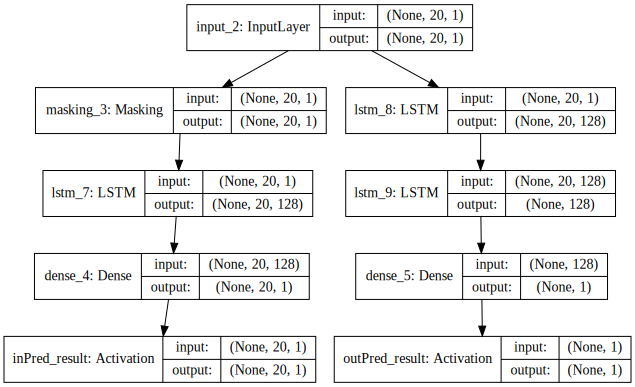

In [39]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


In [36]:
model.fit(trainInput,{"inPred_result": trainInTarget, "outPred_result": trainTarget}, validation_data=(valInput, {"inPred_result": trainValTarget, "outPred_result": valTarget}), batch_size = batch_size, epochs=num_epochs, verbose=1)
# Input prediction is the input vector shifted by 1

Train on 253107 samples, validate on 103072 samples
Epoch 1/30
 31296/253107 [==>...........................] - ETA: 14:29 - loss: 8.6516 - inPred_result_loss: 0.5235 - outPred_result_loss: 8.1281 - inPred_result_acc: 0.0118 - outPred_result_acc: 0.4902

KeyboardInterrupt: ignored

# Testing

# Benchmark

